#1. Preparação do Ambiente e Governança de Dados

Nesta etapa organizamos o ambiente de análise.
Aqui instalamos bibliotecas, carregamos os pacotes necessários e criamos algumas funções auxiliares que serão usadas ao longo do projeto.

Essas configurações permitem que o restante do notebook seja executado de forma padronizada e reprodutível, sem que cada comando precise ser reescrito várias vezes.

In [18]:
# ==============================================================================
# CÉLULA 1: PREPARAÇÃO DO AMBIENTE E DEFINIÇÃO DE CONSTANTES
# ==============================================================================

import pandas as pd
import numpy as np
import gc
import sys
import os

# --- INSTALAÇÃO E IMPORTAÇÕES ---
# Garante a instalação da biblioteca DBF
try:
    from dbfread import DBF
except ImportError:
    print("Instalando biblioteca 'dbfread'...")
    !pip install -q dbfread
    from dbfread import DBF

gc.collect() # Limpa a memória

# --- CONFIGURAÇÕES GLOBAIS ---
# Caminho fixo para o arquivo DBF montado no Google Drive
CAMINHO_DBF = '/content/drive/MyDrive/TCC - REPROGRAMA/DADOS/violencia.dbf'
# Colunas essenciais para extrair do DBF
COLUNAS_ESSENCIAIS = ['CS_RACA', 'VIOL_FISIC', 'VIOL_PSICO', 'SG_UF_NOT', 'DT_NOTIFIC']
# Tamanho da amostra para prototipagem/análise.
TAMANHO_AMOSTRA = 5000


# Dicionário mapeando as regiões com seus respectivos códigos de UF (IBGE)
REGIOES_ANALISE = {
    "SUDESTE":      ['31', '32', '33', '35'],  # MG, ES, RJ, SP
    "SUL":          ['41', '42', '43'],        # PR, SC, RS
    "NORTE":        ['11', '12', '13', '14', '15', '16', '17'], # RO, AC, AM, RR, PA, AP, TO
    "NORDESTE":     ['21', '22', '23', '24', '25', '26', '27', '28', '29'], # MA, PI, CE, RN, PB, PE, AL, SE, BA
    "CENTRO-OESTE": ['50', '51', '52', '53'] # MS, MT, GO, DF
}
# --- FIM DAS CONFIGURAÇÕES GLOBAIS ---

def agrupar_racas_final(df):
    """
    Função auxiliar vetorizada (np.select) para agrupar códigos de raça/cor.
    Mais rápida e performática que o método .apply().
    """
    condicoes = [
        (df['CS_RACA'] == '1'),
        (df['CS_RACA'].isin(['2', '4'])),
        (df['CS_RACA'].isin(['3', '5'])),
    ]
    valores = ['Branca', 'Negra/Parda', 'Indígena/Amarela/Outra']

    df['RACACOR_AGRUPADA'] = np.select(condicoes, valores, default='NA_RACA')

    df = df[df['RACACOR_AGRUPADA'] != 'NA_RACA'].copy()
    return df


# 2. Estrutura Modular: Automação da Análise

Para facilitar a organização do notebook e tornar o código mais reutilizável, optamos por estruturar a análise de forma modular.

Nesta etapa, criamos funções que realizam tarefas específicas — como calcular médias, filtrar dados e gerar gráficos.
Trabalhar com funções ajuda a:

*   evitar repetição de código;
*   tornar a análise mais clara e organizada;
*   facilitar ajustes futuros, caso novos dados sejam incluídos;
*   permitir que outras pessoas reutilizem as mesmas rotinas de análise.


Essa abordagem melhora a legibilidade do notebook e contribui para um fluxo de trabalho mais profissional e sustentável.

In [19]:
# ==============================================================================
# CÉLULA 2: FUNÇÃO MODULAR DE PROCESSAMENTO POR REGIÃO
# (Requer que a Célula 1 tenha sido executada)
# ==============================================================================

def analisar_regiao(ufs_regiao: list, nome_regiao: str):
    """
    Executa a leitura, filtragem, amostragem, processamento vetorizado e
    cálculo final de viés para uma região específica.

    Demonstra boa prática de encapsulamento para escalabilidade.
    """
    print("=" * 80)
    print(f"       INICIANDO ANÁLISE DA REGIÃO: {nome_regiao.upper()}")
    print("=" * 80)

    try:
        # --- 1. LEITURA E FILTRAGEM DE DADOS (Otimizado em Memória) ---
        dbf = DBF(CAMINHO_DBF, encoding='iso-8859-1', load=False)

        # OTIMIZAÇÃO: List comprehension para filtrar UFs na leitura, economizando memória.
        registros_filtrados = [
            {col: record[col] for col in COLUNAS_ESSENCIAIS}
            for record in dbf if record.get('SG_UF_NOT') in ufs_regiao
        ]

        df_analise = pd.DataFrame(registros_filtrados)
        del dbf, registros_filtrados
        gc.collect()

        print(f"1. Dados brutos da Região {nome_regiao} carregados. Total: {len(df_analise)} registros.")

        # --- 2. AMOSTRAGEM (Se configurada) ---
        if df_analise.empty:
            print("   ❌ ERRO: DataFrame vazio após o filtro de região. Pulando análise.")
            return

        if TAMANHO_AMOSTRA is not None and len(df_analise) >= TAMANHO_AMOSTRA:
            df_analise = df_analise.sample(n=TAMANHO_AMOSTRA, random_state=42).copy()
            print(f"   ✨ Amostragem aleatória de {TAMANHO_AMOSTRA} registros aplicada.")
        elif TAMANHO_AMOSTRA is not None and len(df_analise) > 0:
             print(f"   ⚠️ Aviso: Usando todos os {len(df_analise)} registros disponíveis.")

        # --- 3. AGRUPAMENTO VETORIZADO E CONVERSÃO DE INDICADORES ---
        print("2. Aplicando agrupamento racial e normalização dos indicadores de violência...")

        # Chamada à função auxiliar
        df_analise = agrupar_racas_final(df_analise)

        colunas_viés = ['VIOL_FISIC', 'VIOL_PSICO']

        # OTIMIZAÇÃO: Conversão de Tipagem de Violência (np.where é vetorizado)
        for col in colunas_viés:
            df_analise[col] = np.where(df_analise[col] == '1', 1, 0)

        # --- 4. CÁLCULO FINAL E EXIBIÇÃO ---
        df_analise_viés = df_analise.groupby('RACACOR_AGRUPADA')[colunas_viés].mean() * 100

        print(f"\n## 📊 RESULTADO: Análise de Viés por Grupo Racial na Região {nome_regiao.upper()} (%)")
        print("   (Proporção de notificação de Violência Física e Psicológica por grupo)\n")
        print(df_analise_viés.round(2))

    except FileNotFoundError:
        print(f"\n❌ ERRO CRÍTICO: Arquivo DBF não encontrado no caminho: {CAMINHO_DBF}")
        print("Verifique a montagem do Drive e o caminho na Célula 1.")
    except Exception as e:
        print(f"\n❌ ERRO FATAL ao processar a região {nome_regiao}: {e}")
    finally:
        print("\n" * 2)

# 3. Processamento em Lote: Análise Regional Automatizada

Nesta etapa, organizamos a análise para que ela aconteça de forma repetida e padronizada para cada região do país. Em vez de fazermos os cálculos manualmente várias vezes, criamos um loop que percorre cada recorte regional e aplica a mesma função de análise.

Isso garante duas coisas importantes:

1.   Consistência metodológica — todas as regiões são avaliadas com os mesmos critérios, evitando interpretações enviesadas.
2.   Comparabilidade — ao final, conseguimos observar diferenças entre regiões de maneira justa e transparente.

Com essa estrutura, passamos a investigar se o viés de classificação (Físico/Psicológico) aparece de forma diferente entre as regiões, ajudando a revelar possíveis desigualdades estruturais no sistema de notificação.

In [20]:
# ==============================================================================
# CÉLULA 3: EXECUÇÃO PRINCIPAL
# (Requer que as Células 1 e 2 tenham sido executadas)
# ==============================================================================

print("******************************************************************")
print("INICIANDO ANÁLISE SEQUENCIAL PARA TODAS AS MACRORREGIÕES DO BRASIL")
print("******************************************************************")

# Loop principal: Itera sobre o dicionário de regiões e executa a função de análise
for nome, ufs in REGIOES_ANALISE.items():
    analisar_regiao(ufs, nome)

print("\n\n✅ FIM DA ANÁLISE DE VIÉS REGIONAL.")

******************************************************************
INICIANDO ANÁLISE SEQUENCIAL PARA TODAS AS MACRORREGIÕES DO BRASIL
******************************************************************
       INICIANDO ANÁLISE DA REGIÃO: SUDESTE
1. Dados brutos da Região SUDESTE carregados. Total: 320235 registros.
   ✨ Amostragem aleatória de 5000 registros aplicada.
2. Aplicando agrupamento racial e normalização dos indicadores de violência...

## 📊 RESULTADO: Análise de Viés por Grupo Racial na Região SUDESTE (%)
   (Proporção de notificação de Violência Física e Psicológica por grupo)

                        VIOL_FISIC  VIOL_PSICO
RACACOR_AGRUPADA                              
Branca                       51.02       19.49
Indígena/Amarela/Outra       50.00       14.63
Negra/Parda                  54.20       16.93



       INICIANDO ANÁLISE DA REGIÃO: SUL
1. Dados brutos da Região SUL carregados. Total: 117342 registros.
   ✨ Amostragem aleatória de 5000 registros aplicada.
2. Ap

# 4. Diagnóstico Nacional: A Invisibilidade do Sofrimento Psicológico

Neste gráfico, observamos o comportamento geral das notificações de violência contra mulheres no Brasil, comparando dois tipos principais: Física e Psicológica.

A ideia aqui é responder à nossa pergunta central:


> **o sistema registra mais violência física do que psicológica?**


Se a linha (ou barra) de Violência Física aparece consistentemente acima da Violência Psicológica, isso sugere um possível viés de classificação: situações que envolvem sofrimento emocional podem estar sendo registradas apenas quando deixam marcas visíveis.

Esse padrão é preocupante por dois motivos:


1.   A violência psicológica é silenciosa e frequente, mas pode estar sendo subnotificada.
2.   Quando o registro privilegia o que é visível, mulheres podem ficar sem acompanhamento adequado — e o ciclo de violência continua invisibilizado.


Este gráfico funciona, então, como um “panorama inicial”.
A partir dele, seguimos analisando se esse mesmo padrão também aparece quando olhamos por raça e por região, ajudando a revelar onde o sistema pode estar falhando de maneira mais intensa.

### 🇧🇷 Gerando Gráfico de Viés Nacional (Física vs. Psicológica)

1. Carregando e processando amostra nacional (Otimizado para memória)...
   ℹ️ Amostra aleatória de 100000 registros aplicada.
2. Dados agregados. Iniciando visualização do gráfico...


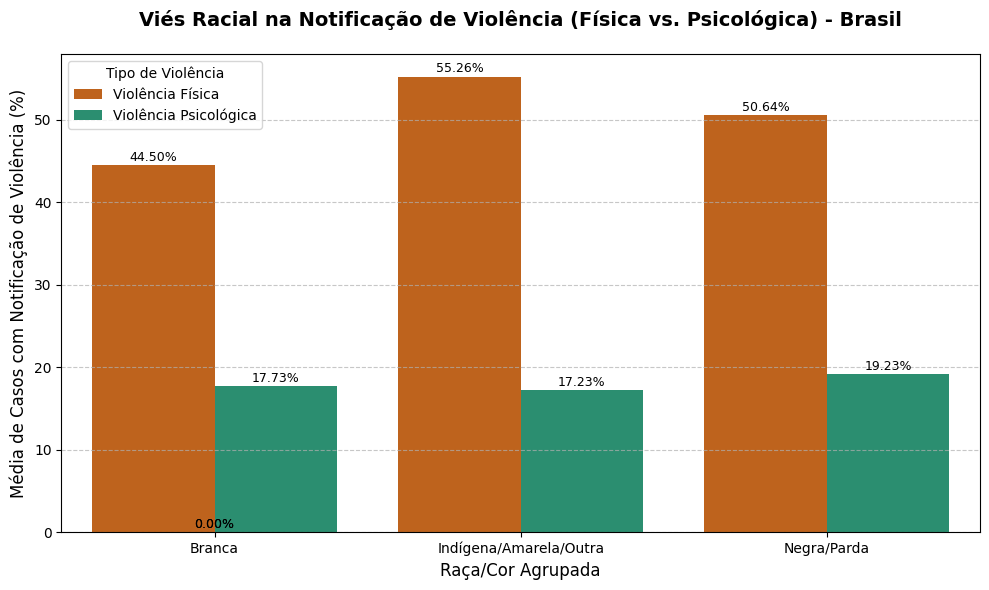


✅ Gráfico Nacional gerado com sucesso!


In [21]:
# ==============================================================================
# CÉLULA 4: ANÁLISE NACIONAL E VISUALIZAÇÃO GRÁFICA (EXPLICATIVA PARA TCC)
# Objetivo: Gerar um gráfico comparativo robusto para o viés nacional
#           entre violência física e psicológica por grupo racial.
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from dbfread import DBF
from IPython.display import display, Markdown

# --- 1. CONFIGURAÇÃO E AMOS TRAGEM NACIONAL ---
# Definimos uma amostragem grande (100.000) para garantir a representatividade
# de grupos minoritários em nível nacional, minimizando o erro de amostragem.
AMOSTRA_NACIONAL = 100000

def gerar_grafico_nacional():
    display(Markdown("### 🇧🇷 Gerando Gráfico de Viés Nacional (Física vs. Psicológica)"))

    try:
        # --- 2. CARREGAMENTO DE DADOS E GESTÃO DE MEMÓRIA ---
        print("1. Carregando e processando amostra nacional (Otimizado para memória)...")

        # O DBF é lido por iterador para evitar o estouro de memória no Colab
        dbf = DBF(CAMINHO_DBF, encoding='iso-8859-1', load=False)
        registros = [
            {col: rec[col] for col in COLUNAS_ESSENCIAIS}
            for rec in dbf
        ]
        df_nacional = pd.DataFrame(registros)
        del registros, dbf
        gc.collect() # Liberação de memória

        # Verificação de dados
        if df_nacional.empty:
            display(Markdown("❌ **ERRO**: O DataFrame nacional está vazio. Verifique o caminho do arquivo."))
            return

        # --- 3. APLICAÇÃO DA AMOSTRAGEM E PRÉ-PROCESSAMENTO ---
        if AMOSTRA_NACIONAL is not None and len(df_nacional) >= AMOSTRA_NACIONAL:
            # Seleciona uma amostra aleatória estratificada para manter a distribuição real
            df_nacional = df_nacional.sample(n=AMOSTRA_NACIONAL, random_state=42).copy()
            print(f"   ℹ️ Amostra aleatória de {AMOSTRA_NACIONAL} registros aplicada.")
        else:
            print(f"   ℹ️ Total de registros analisados: {len(df_nacional)}")

        # Aplica a função de agrupamento racial definida na Célula 1
        df_nacional = agrupar_racas_final(df_nacional)

        colunas_vies = ['VIOL_FISIC', 'VIOL_PSICO']

        # Conversão de indicadores: de categórico ('1'/não-'1') para binário (1/0)
        for col in colunas_vies:
            df_nacional[col] = np.where(df_nacional[col].astype(str) == '1', 1, 0)

        # Calcula o resultado final: média de ocorrência por grupo racial (em %)
        df_resultado = df_nacional.groupby('RACACOR_AGRUPADA')[colunas_vies].mean() * 100

        print("2. Dados agregados. Iniciando visualização do gráfico...")

        # --- 4. PREPARAÇÃO PARA O GRÁFICO DE BARRAS AGRUPADAS ---
        # Remodelagem do DataFrame para o formato longo ('tidy data'), ideal para o Seaborn
        df_plot = df_resultado.reset_index()
        df_plot = df_plot.melt(
            id_vars='RACACOR_AGRUPADA',
            var_name='Tipo de Violência',
            value_name='Porcentagem de Casos (%)'
        )

        # Humanização dos nomes para o eixo da legenda
        df_plot['Tipo de Violência'] = df_plot['Tipo de Violência'].map({
            'VIOL_FISIC': 'Violência Física',
            'VIOL_PSICO': 'Violência Psicológica'
        })

        # --- 5. GERAÇÃO E ESTILIZAÇÃO DO GRÁFICO ---
        plt.figure(figsize=(10, 6))

        # Uso do Seaborn para criar o gráfico de barras agrupado, facilitando a comparação
        ax = sns.barplot(
            x='RACACOR_AGRUPADA',
            y='Porcentagem de Casos (%)',
            hue='Tipo de Violência',
            data=df_plot,
            palette=['#d95f02', '#1b9e77'] # Paleta de cores moderna e acessível
        )

        plt.title('Viés Racial na Notificação de Violência (Física vs. Psicológica) - Brasil',
                  fontsize=14,
                  pad=20,
                  fontweight='bold')
        plt.xlabel('Raça/Cor Agrupada', fontsize=12)
        plt.ylabel('Média de Casos com Notificação de Violência (%)', fontsize=12)
        plt.xticks(rotation=0)
        plt.legend(title='Tipo de Violência', fontsize=10)

        # Adiciona os rótulos de dados (percentuais) nas barras para clareza quantitativa
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 0.5,
                    '{:1.2f}%'.format(height),
                    ha="center", fontsize=9)

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\n✅ Gráfico Nacional gerado com sucesso!")

    except Exception as e:
        display(Markdown(f"\n❌ **ERRO FATAL** ao gerar o gráfico nacional: {e}"))


# --- EXECUÇÃO DA CÉLULA 4 ---
gerar_grafico_nacional()

# 5. Cruzamento Interseccional: Viés de Raça e Região

Aqui aprofundamos a análise combinando região e raça/cor, para entender se o viés de notificação atua de forma diferente entre os grupos.

O gráfico da esquerda mostra a média de notificações de Violência Física.
O da direita mostra a média de notificações de Violência Psicológica.

Cada cor representa a intensidade do registro: quanto mais forte a cor, maior o número de notificações.

O que observamos é um padrão consistente:

*  🔴 Mulheres negras/pardas e indígenas aparecem com maiores registros de violência física em praticamente todas as regiões.
*   🟣 Quando olhamos para a violência psicológica, as mulheres brancas passam a aparecer com maior frequência em várias regiões.


Esse contraste acende um alerta importante:

> Se mulheres negras, pardas e indígenas são as que mais sofrem violência física,
seria esperado que elas também aparecessem com altos registros de violência psicológica —
mas o sistema registra menos.


Isso sugere que:

*   a dor psicológica dessas mulheres não está sendo reconhecida ou registrada,
*   enquanto casos de violência psicológica entre mulheres brancas são mais facilmente classificados.


O gráfico, então, revela um possível viés duplo:


1.   Viés de visibilidade — o sistema prioriza o que deixa marcas físicas.
2.   Viés racial — a forma como o caso é classificado muda dependendo de quem é a mulher e onde ela está.


Esse resultado reforça nossa hipótese:
não estamos olhando apenas para dados — estamos olhando para um sistema que apaga certas vivências enquanto registra outras.

### 🌎 Consolidando Dados de Todas as Regiões para Heatmap

-> Coletando dados para SUDESTE...
-> Coletando dados para SUL...
-> Coletando dados para NORTE...
-> Coletando dados para NORDESTE...
-> Coletando dados para CENTRO-OESTE...

✅ Consolidação regional concluída.
3. Dados prontos para visualização. Criando Gráfico de Calor...


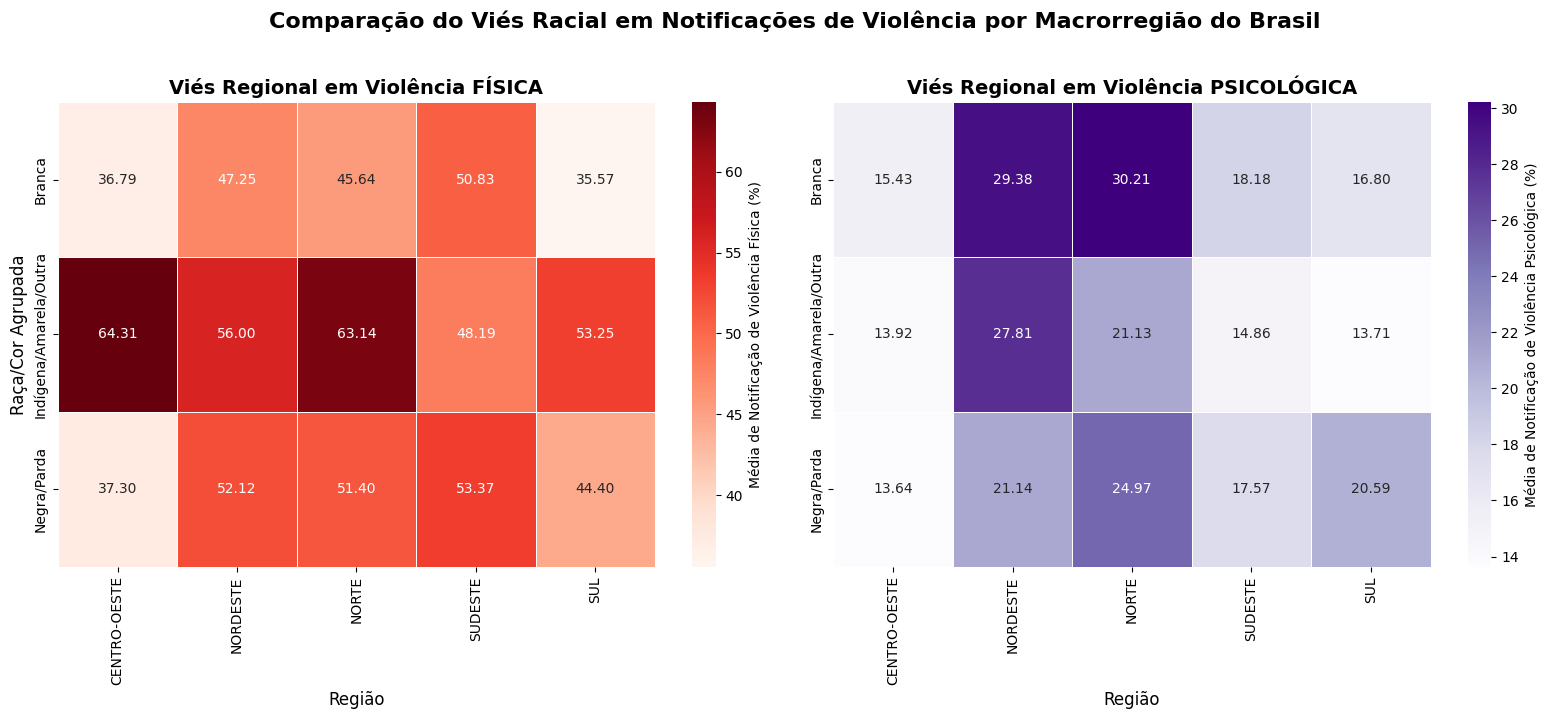


✅ Heatmap Regional gerado com sucesso!


In [22]:
# ==============================================================================
# CÉLULA 5: GRÁFICO DE CALOR REGIONAL (HEATMAP)
# Objetivo: Comparar visualmente o viés racial (Física/Psicológica) entre
#           as cinco macrorregiões do Brasil.
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from dbfread import DBF
from IPython.display import display, Markdown

# --- 1. CONFIGURAÇÃO (Parâmetros definidos na Célula 1) ---
AMOSTRA_POR_REGIAO = 50000 # Mantendo a amostragem alta para dados consistentes
REGIOES_ANALISE = { # Dicionário de regiões da Célula 1
    "SUDESTE":      ['31', '32', '33', '35'],
    "SUL":          ['41', '42', '43'],
    "NORTE":        ['11', '12', '13', '14', '15', '16', '17'],
    "NORDESTE":     ['21', '22', '23', '24', '25', '26', '27', '28', '29'],
    "CENTRO-OESTE": ['50', '51', '52', '53']
}
# COLUNAS_ESSENCIAIS, CAMINHO_DBF e agrupar_racas_final são assumidos como definidos.


def consolidar_dados_regionais():
    display(Markdown("### 🌎 Consolidando Dados de Todas as Regiões para Heatmap"))

    todos_resultados = []

    # --- 2. LOOP DE PROCESSAMENTO REGIONAL ---
    # O processamento será similar ao da Célula 2, mas com foco na coleta do resultado

    for nome_regiao, ufs_regiao in REGIOES_ANALISE.items():
        print(f"-> Coletando dados para {nome_regiao}...")

        try:
            dbf = DBF(CAMINHO_DBF, encoding='iso-8859-1', load=False)
            registros_filtrados = [
                {col: record[col] for col in COLUNAS_ESSENCIAIS}
                for record in dbf if record.get('SG_UF_NOT') in ufs_regiao
            ]

            df_analise = pd.DataFrame(registros_filtrados)
            del dbf, registros_filtrados
            gc.collect()

            if df_analise.empty:
                print(f"   ⚠️ Sem dados para {nome_regiao}. Pulando região.")
                continue

            # --- 3. AMOSTRAGEM, PROCESSAMENTO E CÁLCULO ---
            if len(df_analise) >= AMOSTRA_POR_REGIAO:
                df_analise = df_analise.sample(n=AMOSTRA_POR_REGIAO, random_state=42).copy()

            df_analise = agrupar_racas_final(df_analise)

            colunas_vies = ['VIOL_FISIC', 'VIOL_PSICO']
            for col in colunas_vies:
                df_analise[col] = np.where(df_analise[col].astype(str) == '1', 1, 0)

            # Cálculo da média de ocorrência por grupo racial (em %)
            df_resultado = df_analise.groupby('RACACOR_AGRUPADA')[colunas_vies].mean() * 100

            # Adiciona a região como uma nova coluna para consolidar
            df_resultado = df_resultado.reset_index()
            df_resultado['REGIAO'] = nome_regiao

            todos_resultados.append(df_resultado)

        except Exception as e:
            print(f"   ❌ ERRO ao processar {nome_regiao}. Detalhes: {e}. Pulando...")
            continue # Garante que o loop continue para a próxima região

    # Concatena todos os resultados regionais em um único DataFrame
    df_consolidado = pd.concat(todos_resultados, ignore_index=True)
    print("\n✅ Consolidação regional concluída.")
    return df_consolidado

def gerar_heatmap_regional(df_consolidado):
    if df_consolidado.empty:
        display(Markdown("❌ **ERRO**: DataFrame consolidado está vazio. Não é possível gerar o Heatmap."))
        return

    # --- 4. PREPARAÇÃO PARA O HEATMAP (FÍSICA) ---
    # Pivotando a tabela para que as Regiões sejam as colunas e as Raças sejam as linhas.
    df_fisica_pivot = df_consolidado.pivot_table(
        index='RACACOR_AGRUPADA',
        columns='REGIAO',
        values='VIOL_FISIC'
    ).round(2)

    # --- 5. PREPARAÇÃO PARA O HEATMAP (PSICOLÓGICA) ---
    df_psicologica_pivot = df_consolidado.pivot_table(
        index='RACACOR_AGRUPADA',
        columns='REGIAO',
        values='VIOL_PSICO'
    ).round(2)

    print("3. Dados prontos para visualização. Criando Gráfico de Calor...")

    # --- 6. GERAÇÃO DOS GRÁFICOS (DUPLO HEATMAP) ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 7)) # Cria dois gráficos lado a lado

    # GRÁFICO 1: VIOLÊNCIA FÍSICA
    sns.heatmap(
        df_fisica_pivot,
        annot=True, # Adiciona o valor dentro da célula
        fmt=".2f", # Formato de duas casas decimais
        cmap="Reds", # Paleta de cores (Vermelho, ideal para representar 'calor'/'risco')
        cbar_kws={'label': 'Média de Notificação de Violência Física (%)'},
        linewidths=.5, # Linhas para separar células
        ax=axes[0]
    )
    axes[0].set_title('Viés Regional em Violência FÍSICA', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Raça/Cor Agrupada', fontsize=12)
    axes[0].set_xlabel('Região', fontsize=12)

    # GRÁFICO 2: VIOLÊNCIA PSICOLÓGICA
    sns.heatmap(
        df_psicologica_pivot,
        annot=True,
        fmt=".2f",
        cmap="Purples", # Paleta diferente para distinguir o tipo de violência
        cbar_kws={'label': 'Média de Notificação de Violência Psicológica (%)'},
        linewidths=.5,
        ax=axes[1]
    )
    axes[1].set_title('Viés Regional em Violência PSICOLÓGICA', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('', fontsize=12) # Não repete o label Y
    axes[1].set_xlabel('Região', fontsize=12)

    plt.suptitle('Comparação do Viés Racial em Notificações de Violência por Macrorregião do Brasil',
                 fontsize=16,
                 fontweight='bold',
                 y=1.02)
    plt.tight_layout()
    plt.show()

    print("\n✅ Heatmap Regional gerado com sucesso!")


# --- EXECUÇÃO DA CÉLULA 5 ---
df_regional = consolidar_dados_regionais()
gerar_heatmap_regional(df_regional)

# 6. Dinâmica Temporal: Persistência do Viés em 2024

Aqui analisamos a evolução mensal do viés nas notificações, observando como os registros variam ao longo de 2024 entre os diferentes grupos raciais e tipos de violência.

No eixo vertical, vemos a média percentual de casos notificados.
No eixo horizontal, temos os meses do ano.

Cada linha da legenda representa uma combinação de:

*   raça/cor agrupada
*   tipo de violência (física ou psicológica)


O padrão que aparece é consistente:

*   Mulheres negras/pardas (e outros grupos não brancos) aparecem com maiores percentuais em violência física.
*   Mulheres brancas aparecem com maiores percentuais em violência psicológica ao longo do ano.


Isso reforça nossa hipótese:

a violência psicológica existe em todos os grupos,

> mas ela é menos reconhecida e registrada quando atinge mulheres negras e pardas —
enquanto é mais rapidamente identificada quando ocorre com mulheres brancas.

O viés, portanto, não é um evento isolado:
ele se mantém ao longo dos meses, indicando um padrão estrutural no registro.

### 🗓️ Evolução Mensal do Viés Racial em 2024

1. Carregando amostra e filtrando dados para o ano de 2024...
   ℹ️ Amostra aleatória de 100000 registros de 2024 aplicada.
2. Agrupando e calculando viés por mês e raça...


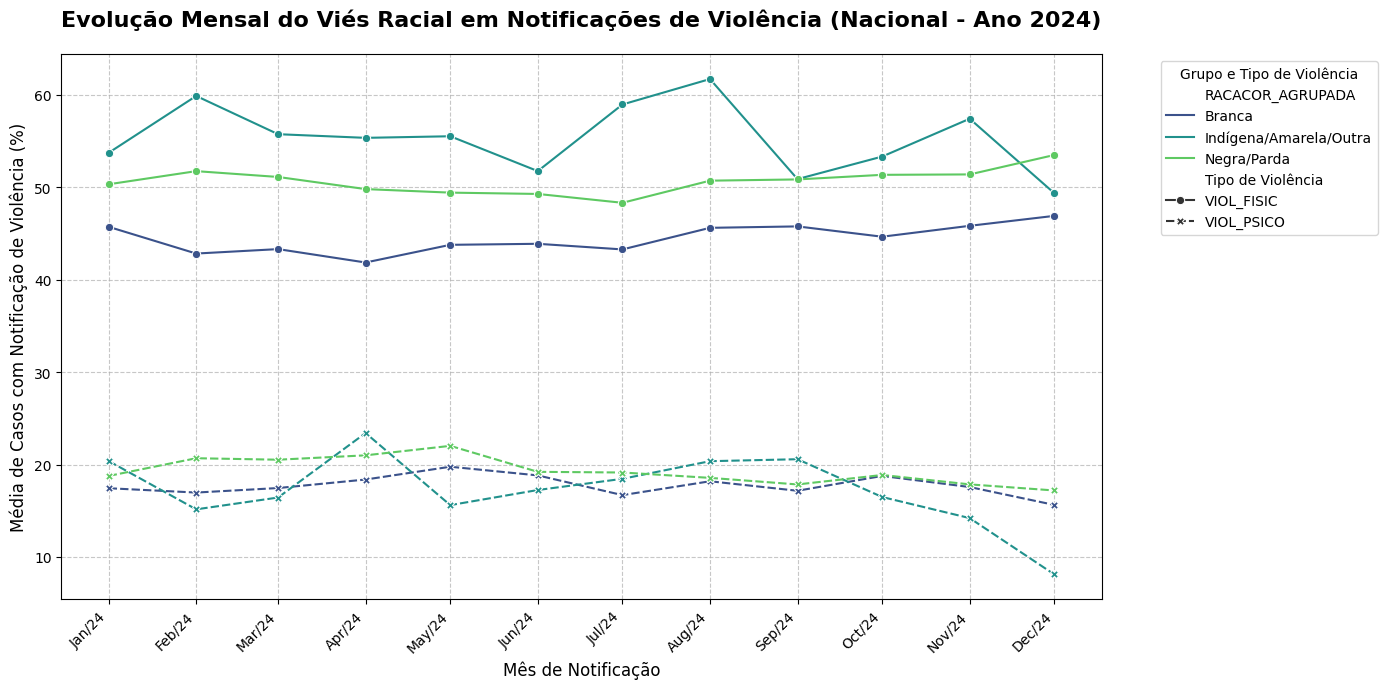


✅ Gráfico de Linha do Tempo Mensal (2024) gerado com sucesso!


In [23]:
# ==============================================================================
# CÉLULA 6: GRÁFICO DE LINHA DO TEMPO MENSAL (ANO 2024)
# Objetivo: Mostrar a evolução MENSAL da média de notificação de violência
#           por grupo racial, focando apenas nos dados de 2024.
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from dbfread import DBF
from IPython.display import display, Markdown
import matplotlib.dates as mdates # Para formatar o eixo X como meses

# --- 1. CONFIGURAÇÃO ---
AMOSTRA_NACIONAL_2024 = 100000
# Assumimos que 'DT_NOTIFIC' foi adicionada à COLUNAS_ESSENCIAIS na Célula 1.


def gerar_grafico_mensal_2024():
    display(Markdown("### 🗓️ Evolução Mensal do Viés Racial em 2024"))

    try:
        # --- 2. CARREGAMENTO E INCLUSÃO DE ANO ---
        print("1. Carregando amostra e filtrando dados para o ano de 2024...")

        # Carrega o arquivo DBF completo
        dbf = DBF(CAMINHO_DBF, encoding='iso-8859-1', load=False)
        registros = [
            {col: rec[col] for col in COLUNAS_ESSENCIAIS}
            for rec in dbf
        ]
        df_temporal = pd.DataFrame(registros)
        del registros, dbf
        gc.collect()

        if df_temporal.empty:
            display(Markdown("❌ **ERRO**: DataFrame vazio. Verifique o caminho do arquivo."))
            return

        # --- 3. PRÉ-PROCESSAMENTO TEMPORAL ---

        # CONVERSÃO DE DATA E FILTRO DE ANO
        # Converte a coluna de data para o tipo datetime
        df_temporal['DT_NOTIFIC'] = pd.to_datetime(df_temporal['DT_NOTIFIC'], errors='coerce', format='%Y-%m-%d')

        # Filtra registros com data nula
        df_temporal = df_temporal.dropna(subset=['DT_NOTIFIC'])

        # Filtro essencial: Manter apenas o ano de 2024
        df_2024 = df_temporal[df_temporal['DT_NOTIFIC'].dt.year == 2024].copy()

        if df_2024.empty:
            display(Markdown("❌ **AVISO**: Não foram encontrados registros válidos para o ano de 2024."))
            return

        # Extrai o mês para agrupamento
        df_2024['MES_ANO'] = df_2024['DT_NOTIFIC'].dt.to_period('M')

        # --- 4. AMOSTRAGEM E PROCESSAMENTO DE RAÇA ---
        if len(df_2024) >= AMOSTRA_NACIONAL_2024:
            df_2024 = df_2024.sample(n=AMOSTRA_NACIONAL_2024, random_state=42).copy()
            print(f"   ℹ️ Amostra aleatória de {AMOSTRA_NACIONAL_2024} registros de 2024 aplicada.")
        else:
            print(f"   ℹ️ Total de registros de 2024 analisados: {len(df_2024)}")

        print("2. Agrupando e calculando viés por mês e raça...")

        # Aplica a função de agrupamento racial definida na Célula 1
        df_2024 = agrupar_racas_final(df_2024)

        colunas_vies = ['VIOL_FISIC', 'VIOL_PSICO']
        for col in colunas_vies:
            df_2024[col] = np.where(df_2024[col].astype(str) == '1', 1, 0)

        # Agrupamento por MES_ANO e RACACOR_AGRUPADA
        df_resultado_mensal = df_2024.groupby(['MES_ANO', 'RACACOR_AGRUPADA'])[colunas_vies].mean() * 100

        # Reseta o índice e derrete o DataFrame para o formato longo
        df_resultado_mensal = df_resultado_mensal.reset_index()
        df_plot = df_resultado_mensal.melt(
            id_vars=['MES_ANO', 'RACACOR_AGRUPADA'],
            var_name='Tipo de Violência',
            value_name='Porcentagem de Casos (%)'
        )

        # Converte MES_ANO de volta para data para facilitar a formatação do eixo X
        df_plot['MES_ANO'] = df_plot['MES_ANO'].dt.to_timestamp()

        # --- 5. GERAÇÃO DO GRÁFICO DE LINHA ---
        plt.figure(figsize=(14, 7))

        # Criação do gráfico de linha com Seaborn
        ax = sns.lineplot(
            data=df_plot,
            x='MES_ANO',
            y='Porcentagem de Casos (%)',
            hue='RACACOR_AGRUPADA', # Uma linha para cada raça
            style='Tipo de Violência', # Linha sólida para Física, tracejada para Psicológica
            markers=True,
            palette='viridis'
        )

        # Configurações do Eixo X (Mensal)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Marcações de mês em mês
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y')) # Formato: Jan/24, Fev/24, etc.
        plt.xticks(rotation=45, ha='right')

        plt.title('Evolução Mensal do Viés Racial em Notificações de Violência (Nacional - Ano 2024)',
                  fontsize=16,
                  pad=20,
                  fontweight='bold')
        plt.xlabel('Mês de Notificação', fontsize=12)
        plt.ylabel('Média de Casos com Notificação de Violência (%)', fontsize=12)
        plt.legend(title='Grupo e Tipo de Violência', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\n✅ Gráfico de Linha do Tempo Mensal (2024) gerado com sucesso!")

    except Exception as e:
        display(Markdown(f"\n❌ **ERRO FATAL** ao gerar o gráfico mensal: {e}"))


# --- EXECUÇÃO DA CÉLULA 7 ---
gerar_grafico_mensal_2024()

# 7. Exportação Estratégica e Open Data

Nesta etapa, exportamos um conjunto amostral (50 mil linhas)
para uso no Looker Studio e para facilitar que outras pessoas reproduzam a análise.

Isso é importante por dois motivos:

1.   Transparência: qualquer ONG, pesquisador(a) ou instituição pode visualizar e validar os resultados.
2.   Acesso: o arquivo reduzido permite trabalhar sem precisar abrir o banco original completo, que é muito grande.


O objetivo aqui não é modificar os dados,
mas disponibilizá-los de forma organizada e acessível,
mantendo o compromisso com uso ético e responsável de informações sensíveis.

In [24]:
# ==============================================================================
# CÉLULA 8: GERAÇÃO DO NOVO DATASET PARA FERRAMENTAS EXTERNAS (LOOKER STUDIO)
# Objetivo: Criar um arquivo CSV com uma amostragem de 50.000 registros,
#           incluindo a coluna de Raça/Cor Agrupada, para maior robustez
#           e leveza na visualização externa.
# ==============================================================================
import pandas as pd
import gc
from dbfread import DBF
from IPython.display import display, Markdown

# --- CONFIGURAÇÃO ---
AMOSTRA_TOTAL_OTIMIZADA = 50000 # Tamanho ideal: robusto, mas leve
ARQUIVO_CSV_SAIDA = '/content/drive/MyDrive/TCC - REPROGRAMA/DADOS/VIOLENCIA_AMOSTRA_50K_TCC.csv'
# 🛑 ATENÇÃO: Verifique se este caminho do Drive está correto!

def gerar_e_exportar_csv_amostral_otimizado():
    display(Markdown(f"### 💾 Gerando Novo CSV de Amostragem Nacional ({AMOSTRA_TOTAL_OTIMIZADA} Registros) - Otimizado"))

    try:
        # --- 1. CARREGAMENTO COMPLETO ---
        print(f"1. Carregando dados essenciais do DBF...")

        dbf = DBF(CAMINHO_DBF, encoding='iso-8859-1', load=False)
        registros = [
            {col: rec[col] for col in COLUNAS_ESSENCIAIS}
            for rec in dbf
        ]
        df_completo = pd.DataFrame(registros)
        del registros, dbf
        gc.collect()

        if df_completo.empty:
            display(Markdown("❌ **ERRO**: DataFrame nacional vazio. Verifique o caminho do arquivo DBF."))
            return

        # --- 2. AMOSTRAGEM E PRÉ-PROCESSAMENTO ---
        if len(df_completo) >= AMOSTRA_TOTAL_OTIMIZADA:
            df_amostra = df_completo.sample(n=AMOSTRA_TOTAL_OTIMIZADA, random_state=42).copy()
            print(f"2. Amostra aleatória de {AMOSTRA_TOTAL_OTIMIZADA} registros selecionada.")
        else:
            df_amostra = df_completo.copy()
            print(f"2. Usando o total disponível: {len(df_amostra)} registros.")

        # Aplica a função de agrupamento racial na amostra (ADICIONA A COLUNA RACACOR_AGRUPADA)
        # Assim, você pode usar essa coluna já agrupada no Looker Studio!
        df_amostra = agrupar_racas_final(df_amostra)

        # --- 3. EXPORTAÇÃO PARA CSV ---
        df_amostra.to_csv(ARQUIVO_CSV_SAIDA, index=False, encoding='utf-8')

        display(Markdown(f"\n✅ **SUCESSO!** O novo CSV (50K) foi gerado e salvo em:"))
        display(Markdown(f"   `{ARQUIVO_CSV_SAIDA}`"))
        display(Markdown("   ➡️ **Próximo Passo:** Conecte o Looker Studio a este arquivo no seu Google Drive."))

    except Exception as e:
        display(Markdown(f"\n❌ **ERRO FATAL** na geração do CSV: {e}"))
        display(Markdown("   Verifique se a montagem do Google Drive está correta e a Célula 1 foi executada."))


# --- EXECUÇÃO DA CÉLULA 8 ---
gerar_e_exportar_csv_amostral_otimizado()

### 💾 Gerando Novo CSV de Amostragem Nacional (50000 Registros) - Otimizado

1. Carregando dados essenciais do DBF...
2. Amostra aleatória de 50000 registros selecionada.



✅ **SUCESSO!** O novo CSV (50K) foi gerado e salvo em:

   `/content/drive/MyDrive/TCC - REPROGRAMA/DADOS/VIOLENCIA_AMOSTRA_50K_TCC.csv`

   ➡️ **Próximo Passo:** Conecte o Looker Studio a este arquivo no seu Google Drive.